# **Gesture Recognition Model**
* Development of a Neural Network-based smart-TV feature that can recognise five different gestures performed by the user to control the TV without using a remote. The gestures are continuously monitored by the webcam mounted on the TV.
* Each gesture corresponds to a specific command:
>* Thumbs Up	- Increase the volume.
>* Thumbs Down	- Decrease the volume.
>* Left Swipe	- 'Jump' backwards 10 seconds.
>* Right Swipe	- 'Jump' forward 10 seconds.
>* Stop	- Pause the movie.

* The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use.  
* The zipped data file contains a 'train' and a 'val' folder with two CSV files for the two folders. These folders are in turn divided into subfolders where each subfolder represents a video of a particular gesture. Each subfolder, i.e. a video, contains 30 frames (or images). While all images in a particular video subfolder have the same dimensions, different videos may have different dimensions. Specifically, videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos). (Hence, pre-processing is required to standardise the videos.)
Each row of the CSV file represents one video and contains three main pieces of information - the name of the subfolder containing the 30 images of the video, the name of the gesture and the numeric label (between 0-4) of the video.


**Importing necessary libraries**

In [ ]:
import numpy as np
import os
import cv2
import imageio
import datetime
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout,GlobalAveragePooling3D,ConvLSTM2D,GlobalAveragePooling2D
from keras.layers.convolutional import Conv3D,Conv2D, MaxPooling3D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Initialization**: We set the random seed in order to prevent drastic variation in the results.

In [ ]:
# Setting random seeds for reproducibility
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

**Reading the data**: Reading the dataset provided and setting the batch size to 32

In [ ]:
# Defining data paths and setting hyperparameters
# Reading and shuffling the training and validation data
train_doc = np.random.permutation(open('/kaggle/input/gesturerecognision/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/kaggle/input/gesturerecognision/Project_data/val.csv').readlines())
batch_size = 32

## Generator
**Data Preprocessing**
*   Defining a generator function to preprocess and yield batches of video frames.
*   Inside the generator:
>*  Random permutation of the list of video folders.
>*  Calculation of the number of batches based on batch size.
>*  For each batch:
>> * Initialization of arrays for batch data and labels.
>> * Iteration over the videos in the batch:
>>>* Reading and preprocessing of each frame from the video.
>>>* Normalization and storing the frame data in the batch data.
>>>* Creation of one-hot encoded labels for the corresponding gesture.
>*   Yielding the batch data and labels.



In [ ]:
#defining the generator
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx =  range(1,28,2)
    while True:
        t = np.random.permutation(folder_list)
        x = len(img_idx)
        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1
        for batch in range(num_batches): # iteration over the number of batches
            batch_data = np.zeros((batch_size,x,120,120,3)) # x is the number of images used for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iteration over the batch size
                folder_idx = folder + (batch*batch_size)
                if folder_idx >= len(t):
                    break
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iteration over the frames/images of a folder in order to read them
                    image = imageio.v2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    # cropping and resizing the images
                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]
                    resized_im = cv2.resize(image, (120,120))
                    batch_data[folder,idx,:,:,0] =  resized_im[:,:,0]/255 #normalising and feeding the image
                    batch_data[folder,idx,:,:,1] =  resized_im[:,:,1]/255
                    batch_data[folder,idx,:,:,2] =  resized_im[:,:,2]/255

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [ ]:
#Initializing the train and validation path
curr_dt_time = datetime.datetime.now()
train_path = '/kaggle/input/gesturerecognision/Project_data/train'
val_path = '/kaggle/input/gesturerecognision/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30  # the number of epochs have been experimented with and set as such for its optimal outcome
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


In [ ]:
#Setting the input shape and random seed
seq_idx = range(1,28,2)
input_shape = (len(seq_idx), 120, 120, 3)  # input shape
np.random.seed(30)

In [ ]:
#Initializing the steps per epoch
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


def plot(history):    # function to plot the training/validation accuracies and losses
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

### **Model architecture**: We use two different model architectures, namely
### (1) 3D Convolutional model and (2) TimeDistributed CNN-RNN stack.

In [ ]:
#Choosing optimizer as Adam with lerning rate as 0.01
optimiser = optimizers.Adam(lr=0.01)

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## **Architecture I**
### **Model 1: 3D Convolution + Maxpooling + Flatten**

In [ ]:
#Defining the model
 model = Sequential()
 model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
 model.add(MaxPooling3D(pool_size=2))

 model.add(Conv3D(64, kernel_size=3, activation='relu'))
 model.add(MaxPooling3D(pool_size=2))

 model.add(Flatten())
 model.add(Dense(256, activation='relu'))
 model.add(Dense(5, activation='softmax'))



In [ ]:
# model compilation
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 12, 118, 118, 32)  2624      
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 6, 59, 59, 32)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 4, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 2, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_8 (Dense)             (None, 256)              

In [ ]:
#creating train and validation generator
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

#creating Callback list
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [ LR]
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesturerecognision/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - 54s 3s/step - loss: 58.7680 - categorical_accuracy: 0.1935 - val_loss: 1.2610 - val_categorical_accuracy: 0.1250 - lr: 0.0100
Epoch 2/30
21/21 [==============================] - 40s 2s/step - loss: 1.5908 - categorical_accuracy: 0.1830 - val_loss: 1.2577 - val_categorical_accuracy: 0.3594 - lr: 0.0100
Epoch 3/30
21/21 [==============================] - 39s 2s/step - loss: 1.6406 - categorical_accuracy: 0.1905 - val_loss: 1.2555 - val_categorical_accuracy: 0.1484 - lr: 0.0100
Epoch 4/30
21/21 [==============================] - 38s 2s/step - loss: 1.5876 - categorical_accuracy: 0.2173 - val_loss: 1.2562 - val_categorical_accuracy: 0.3672 - lr: 0.0100
Epoch 5/30
21/21 [==============================] - 39s 2s/step - loss: 1.5886 - categorical_accuracy: 0.1801 - val_loss: 1.2565 - val_categorical_accuracy: 0.1797 - lr: 0.0100
Epoch 6/30
21/21 [===========

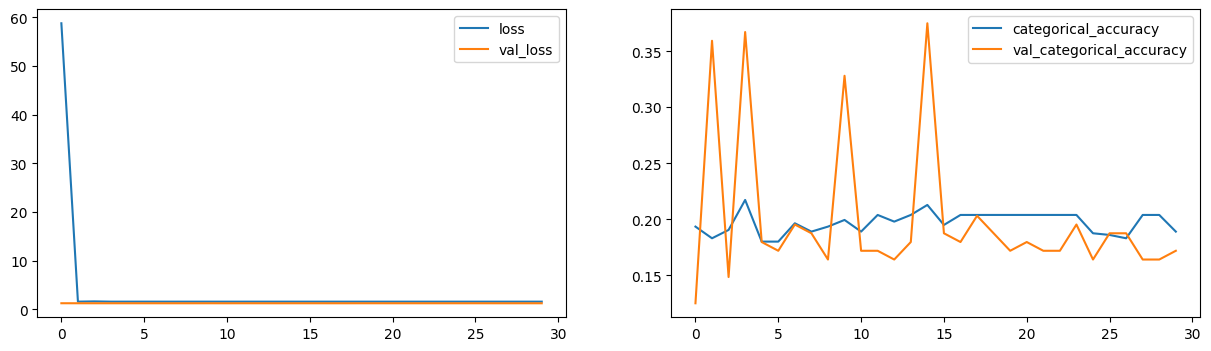

In [ ]:
#Plotting the accuracy and loss for validation and categorical values
plot(history)

### **Model 2: Increased number of layers of 3D Convolution + Maxpooling + Flatten**

In [ ]:
#Creating the Model
 model = Sequential()

 model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
 model.add(Conv3D(64, kernel_size=3, activation='relu'))
 model.add(MaxPooling3D(pool_size=(2, 2, 2)))

 model.add(Conv3D(128, kernel_size=3, activation='relu'))
 model.add(MaxPooling3D(pool_size=(2, 2, 2)))

 model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu'))
 model.add(MaxPooling3D(pool_size=(3, 2, 2)))

 model.add(Conv3D(512, kernel_size=(3, 3, 3), activation='relu'))
 model.add(Conv3D(512, kernel_size=(3, 3, 3), activation='relu'))
 model.add(MaxPooling3D(pool_size=(2, 2, 2)))

 model.add(Flatten())
 model.add(Dense(512, activation='relu'))
 model.add(Dense(5, activation='softmax'))

**Result: We observe generator error because of  higher spatial diention.**

### **Model 3: Increased number of layers of 3D Convolution + Maxpooling with lower spatial dimension + Flatten**

In [ ]:
#Creating the model
 model = Sequential()

 model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
 model.add(Conv3D(64, kernel_size=3, activation='relu'))
 model.add(MaxPooling3D(pool_size=(2, 2, 2)))

 model.add(Conv3D(128, kernel_size=3, activation='relu'))
 model.add(MaxPooling3D(pool_size=(1, 2, 2)))

 model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
 model.add(MaxPooling3D(pool_size=(1, 2, 2)))

 model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
 model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
 model.add(MaxPooling3D(pool_size=(1, 2, 2)))

 model.add(Flatten())
 model.add(Dense(512, activation='relu'))
 model.add(Dense(5, activation='softmax'))


In [ ]:
# model compilation

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 12, 118, 118, 32)  2624      
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 116, 116, 64)  55360     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 58, 58, 64)    0         
 )                                                               
                                                                 
 conv3d_2 (Conv3D)           (None, 3, 56, 56, 128)    221312    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 3, 28, 28, 128)   0         
 3D)                                                             
                                                                 
 conv3d_3 (Conv3D)           (None, 3, 26, 26, 256)    2

In [ ]:
#Creating train and Validation generator
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

#defining callback and fitting the model
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [ LR]
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesturerecognision/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - 52s 2s/step - loss: 11.4973 - categorical_accuracy: 0.2039 - val_loss: 1.2580 - val_categorical_accuracy: 0.1797 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - 40s 2s/step - loss: 1.5903 - categorical_accuracy: 0.1935 - val_loss: 1.2560 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - 42s 2s/step - loss: 1.5880 - categorical_accuracy: 0.1756 - val_loss: 1.2576 - val_categorical_accuracy: 0.3594 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - 38s 2s/step - loss: 1.5878 - categorical_accuracy: 0.1801 - val_loss: 1.2562 - val_categorical_accuracy: 0.1797 - lr: 0.0010
Epoch 5/30
21/21 [==============================] - 40s 2s/step - loss: 1.5877 - categorical_accuracy: 0.1920 - val_loss: 1.2553 - val_categorical_accuracy: 0.1641 - lr: 0.0010
Epoch 6/30
21/21 [===========

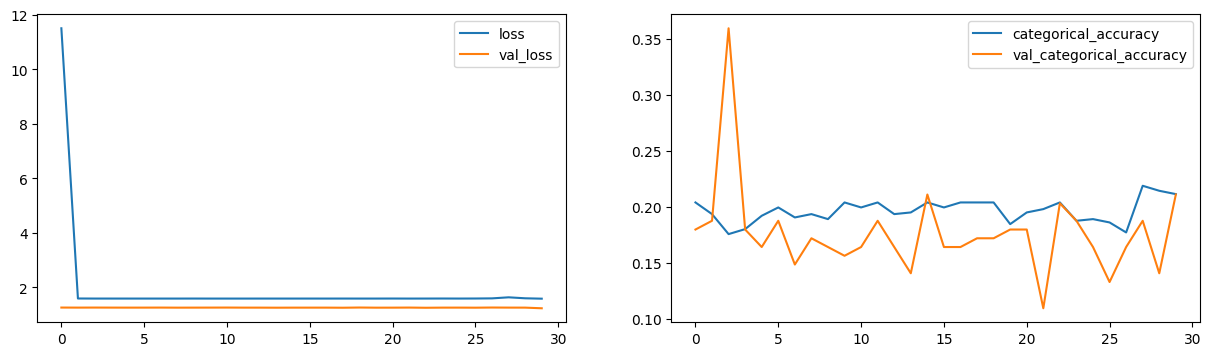

In [ ]:
#Plotting the graph for catagorical and validation accuracy and loss
plot(history)

### **Model 4: Increased number of layers of 3D Convolution + Maxpooling with lower spatial dimension + Flatten + Batch normalization**

In [ ]:
#Creating the model
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [ ]:
# model compilation
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 12, 118, 118, 32)  2624      
                                                                 
 conv3d_7 (Conv3D)           (None, 10, 116, 116, 64)  55360     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 5, 58, 58, 64)    0         
 3D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 5, 58, 58, 64)    256       
 ormalization)                                                   
                                                                 
 conv3d_8 (Conv3D)           (None, 3, 56, 56, 128)    221312    
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 3, 28, 28, 128)  

In [ ]:
#Creating train and Validation generator
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

#defining callback and fitting the model
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [ LR]
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /kaggle/input/gesturerecognision/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - 122s 5s/step - loss: 2.7561 - categorical_accuracy: 0.3229 - val_loss: 4942.6543 - val_categorical_accuracy: 0.1797 - lr: 0.0100
Epoch 2/30
21/21 [==============================] - 43s 2s/step - loss: 1.4231 - categorical_accuracy: 0.4628 - val_loss: 478.0140 - val_categorical_accuracy: 0.1953 - lr: 0.0100
Epoch 3/30
21/21 [==============================] - 43s 2s/step - loss: 1.2215 - categorical_accuracy: 0.5179 - val_loss: 71.1827 - val_categorical_accuracy: 0.2656 - lr: 0.0100
Epoch 4/30
21/21 [==============================] - 42s 2s/step - loss: 1.0470 - categorical_accuracy: 0.5848 - val_loss: 33.2503 - val_categorical_accuracy: 0.1719 - lr: 0.0100
Epoch 5/30
21/21 [==============================] - 43s 2s/step - loss: 0.9454 - categorical_accuracy: 0.6057 - val_loss: 9.4370 - val_categorical_accuracy: 0.1875 - lr: 0.0100
Epoch 6/30
21/21 [====

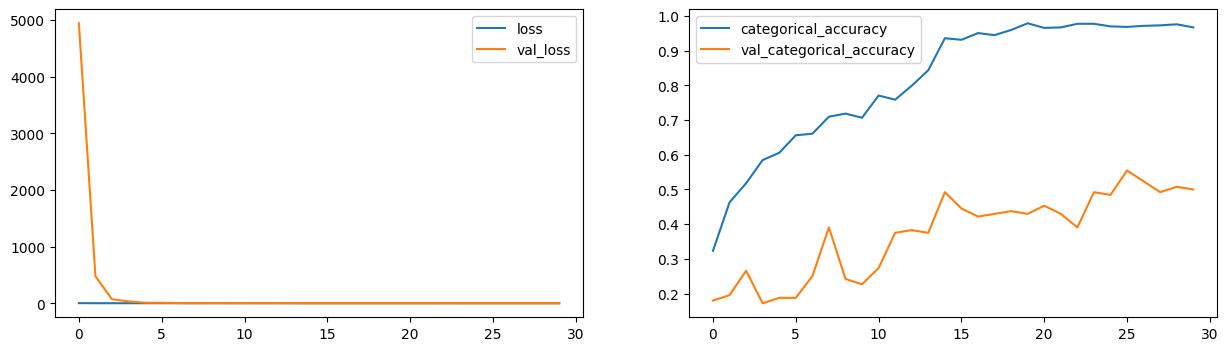

In [ ]:
#Plotting the graph for catagorical and validation accuracy and loss
plot(history)

### **Model 5: Increased number of layers of 3D Convolution + Maxpooling with lower spatial dimension + Flatten + Droupouts + batch normalization**

In [ ]:
#Creating the model
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))


In [ ]:
# model compilation
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 12, 118, 118, 32)  2624      
                                                                 
 conv3d_13 (Conv3D)          (None, 10, 116, 116, 64)  55360     
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 5, 58, 58, 64)    0         
 3D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 5, 58, 58, 64)    256       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 5, 58, 58, 64)     0         
                                                                 
 conv3d_14 (Conv3D)          (None, 3, 56, 56, 128)   

In [ ]:
#Creating train and Validation generator
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


#defining callback and fitting the model
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [ LR]
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesturerecognision/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - 49s 2s/step - loss: 2.8075 - categorical_accuracy: 0.4673 - val_loss: 795.1632 - val_categorical_accuracy: 0.1797 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - 43s 2s/step - loss: 0.9592 - categorical_accuracy: 0.6205 - val_loss: 90.3868 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - 44s 2s/step - loss: 0.6580 - categorical_accuracy: 0.7470 - val_loss: 48.1304 - val_categorical_accuracy: 0.1484 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - 41s 2s/step - loss: 0.5345 - categorical_accuracy: 0.7753 - val_loss: 19.6358 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 5/30
21/21 [==============================] - 40s 2s/step - loss: 0.4587 - categorical_accuracy: 0.8170 - val_loss: 12.1583 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 6/30
21/21 [======

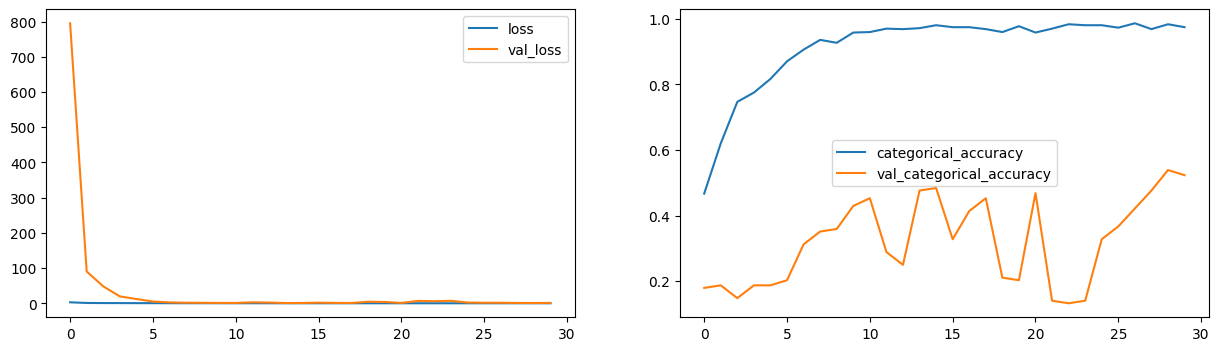

In [ ]:
#Plotting the graph for catagorical and validation accuracy and loss
plot(history)

### **Model 6: Increased number of layers of 3D Convolution + Maxpooling with lower spatial dimension + Flatten + Droupouts with 50% active neurons + batch normalization**

In [ ]:
#Creating the model
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))


In [ ]:
# model compilation
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 12, 118, 118, 32)  2624      
                                                                 
 conv3d_17 (Conv3D)          (None, 10, 116, 116, 64)  55360     
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 5, 58, 58, 64)    0         
 g3D)                                                            
                                                                 
 batch_normalization_9 (Batc  (None, 5, 58, 58, 64)    256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 5, 58, 58, 64)     0         
                                                                 
 conv3d_18 (Conv3D)          (None, 3, 56, 56, 128)   

In [ ]:
#Creating train and Validation generator
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

#defining callback and fitting the model
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [ LR]
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /kaggle/input/gesturerecognision/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - 44s 2s/step - loss: 2.8996 - categorical_accuracy: 0.3497 - val_loss: 2793.2610 - val_categorical_accuracy: 0.4219 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - 39s 2s/step - loss: 1.3228 - categorical_accuracy: 0.4494 - val_loss: 73.2393 - val_categorical_accuracy: 0.2422 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - 39s 2s/step - loss: 1.1203 - categorical_accuracy: 0.5312 - val_loss: 57.0259 - val_categorical_accuracy: 0.1719 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - 37s 2s/step - loss: 1.0619 - categorical_accuracy: 0.5595 - val_loss: 9.1180 - val_categorical_accuracy: 0.2031 - lr: 0.0010
Epoch 5/30
21/21 [==============================] - 39s 2s/step - loss: 0.9041 - categorical_accuracy: 0.6027 - val_loss: 6.3704 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 6/30
21/21 [=======

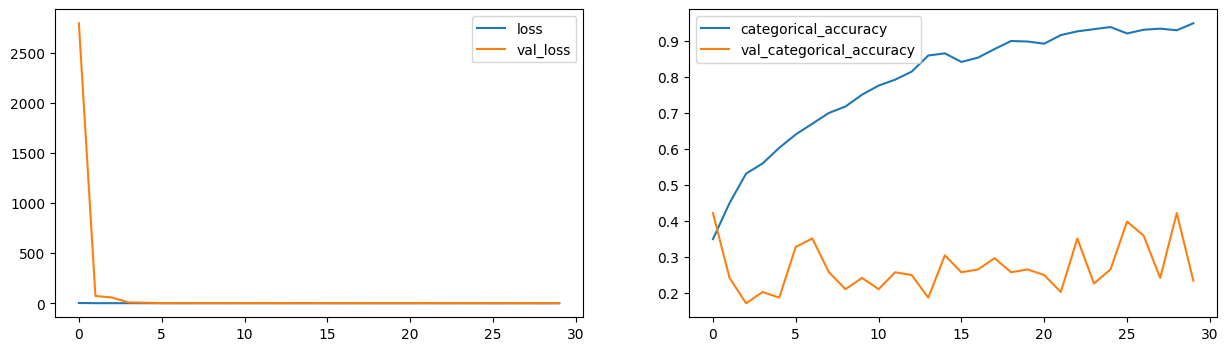

In [ ]:
#Plotting the graph for catagorical and validation accuracy and loss
plot(history)

### **Model 7: Increased number of layers of 3D Convolution + Maxpooling with lower spatial dimension + GlobalAveragePooling3D + Droupouts + Batch normalization**

In [ ]:
#Creating the model
 model = Sequential()

 model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
 model.add(Conv3D(64, kernel_size=3, activation='relu'))
 model.add(MaxPooling3D(pool_size=(2, 2, 2)))
 model.add(BatchNormalization())
 model.add(Dropout(0.2))

 model.add(Conv3D(128, kernel_size=3, activation='relu'))
 model.add(MaxPooling3D(pool_size=(1, 2, 2)))
 model.add(BatchNormalization())
 model.add(Dropout(0.2))

 model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
 model.add(MaxPooling3D(pool_size=(1, 2, 2)))
 model.add(BatchNormalization())
 model.add(Dropout(0.2))

 model.add(GlobalAveragePooling3D())
 model.add(Dense(512, activation='relu'))
 model.add(BatchNormalization())
 model.add(Dense(5, activation='softmax'))


In [ ]:
# model compilation
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_22 (Conv3D)          (None, 12, 118, 118, 32)  2624      
                                                                 
 conv3d_23 (Conv3D)          (None, 10, 116, 116, 64)  55360     
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 5, 58, 58, 64)    0         
 g3D)                                                            
                                                                 
 batch_normalization_14 (Bat  (None, 5, 58, 58, 64)    256       
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 5, 58, 58, 64)     0         
                                                                 
 conv3d_24 (Conv3D)          (None, 3, 56, 56, 128)   

In [ ]:
#Creating train and Validation generator
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

#defining callback and fitting the model
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [ LR]
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /kaggle/input/gesturerecognision/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - 43s 2s/step - loss: 1.9556 - categorical_accuracy: 0.3378 - val_loss: 144.3380 - val_categorical_accuracy: 0.1406 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - 38s 2s/step - loss: 1.2428 - categorical_accuracy: 0.4330 - val_loss: 55.4081 - val_categorical_accuracy: 0.2188 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - 38s 2s/step - loss: 1.2029 - categorical_accuracy: 0.4673 - val_loss: 31.8167 - val_categorical_accuracy: 0.1719 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - 37s 2s/step - loss: 1.1589 - categorical_accuracy: 0.4613 - val_loss: 9.7144 - val_categorical_accuracy: 0.3516 - lr: 0.0010
Epoch 5/30
21/21 [==============================] - 38s 2s/step - loss: 1.0698 - categorical_accuracy: 0.5179 - val_loss: 5.8368 - val_categorical_accuracy: 0.1797 - lr: 0.0010
Epoch 6/30
21/21 [========

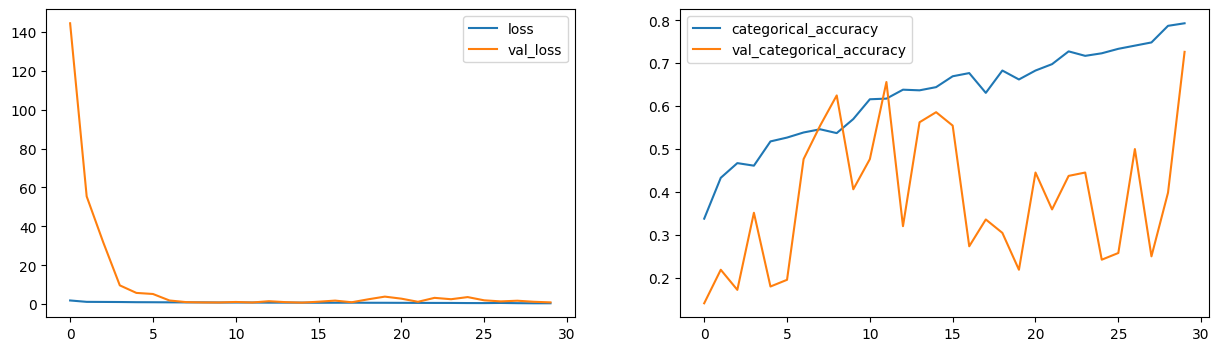

In [ ]:
#Plotting the graph for catagorical and validation accuracy and loss
plot(history)

## **Architecture II**
### **Model 1: TimeDistributed 2D Convolution + GlobalAveragePooling3D + Batch normalization**

In [ ]:
#Creating the model
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(GlobalAveragePooling3D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))


In [ ]:
# model compilation
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 14, 118, 118, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 14, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization_18 (Bat  (None, 14, 59, 59, 32)   128       
 chNormalization)                                                
                                                                 
 time_distributed_2 (TimeDis  (None, 14, 57, 57, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 14, 28, 28, 64)  

In [ ]:

#Creating train and Validation generator
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


#defining callback and fitting the model
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [ LR]
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesturerecognision/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - 45s 2s/step - loss: 1.5492 - categorical_accuracy: 0.4211 - val_loss: 3.9677 - val_categorical_accuracy: 0.1797 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - 39s 2s/step - loss: 1.1043 - categorical_accuracy: 0.5149 - val_loss: 2.4131 - val_categorical_accuracy: 0.1719 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - 39s 2s/step - loss: 1.0678 - categorical_accuracy: 0.5461 - val_loss: 1.5617 - val_categorical_accuracy: 0.2344 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - 39s 2s/step - loss: 0.8516 - categorical_accuracy: 0.6622 - val_loss: 1.8130 - val_categorical_accuracy: 0.1719 - lr: 0.0010
Epoch 5/30
21/21 [==============================] - 39s 2s/step - loss: 0.7964 - categorical_accuracy: 0.6860 - val_loss: 2.4376 - val_categorical_accuracy: 0.1719 - lr: 0.0010
Epoch 6/30
21/21 [============

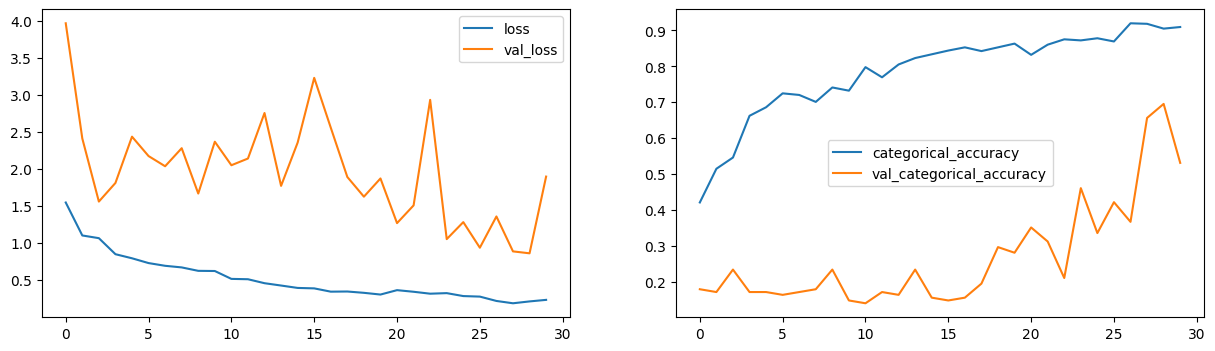

In [ ]:
#Plotting the graph for catagorical and validation accuracy and loss
plot(history)

### **Model 2: TimeDistributed + ConvLSTM2D + GlobalAveragePooling3D + batch normalization**

In [ ]:
 #Creating the model
 model = Sequential()
 model.add(TimeDistributed(Conv2D(8, (3,3), activation='relu'), input_shape=input_shape))
 model.add(BatchNormalization())
 model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))
 model.add(BatchNormalization())
 model.add(ConvLSTM2D(8, kernel_size = 3, return_sequences=False))
 model.add(BatchNormalization())
 model.add(TimeDistributed(Dense(64, activation='relu')))
 model.add(BatchNormalization())
 model.add(GlobalAveragePooling2D())
 model.add(Dense(64, activation='relu'))
 model.add(Dense(5, activation='softmax'))


In [ ]:
# model compilation
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 14, 118, 118, 8)  224       
 tributed)                                                       
                                                                 
 batch_normalization_22 (Bat  (None, 14, 118, 118, 8)  32        
 chNormalization)                                                
                                                                 
 time_distributed_7 (TimeDis  (None, 14, 116, 116, 16)  1168     
 tributed)                                                       
                                                                 
 batch_normalization_23 (Bat  (None, 14, 116, 116, 16)  64       
 chNormalization)                                                
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 114, 114, 8)      

In [ ]:
#Creating train and Validation generator
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


#defining callback and fitting the model
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [ LR]
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /kaggle/input/gesturerecognision/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - 46s 2s/step - loss: 1.3672 - categorical_accuracy: 0.3720 - val_loss: 1.2515 - val_categorical_accuracy: 0.1484 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - 39s 2s/step - loss: 1.1595 - categorical_accuracy: 0.4658 - val_loss: 1.2901 - val_categorical_accuracy: 0.1797 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - 39s 2s/step - loss: 1.0086 - categorical_accuracy: 0.5655 - val_loss: 1.4027 - val_categorical_accuracy: 0.1562 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - 38s 2s/step - loss: 0.9368 - categorical_accuracy: 0.5833 - val_loss: 1.3487 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 5/30
21/21 [==============================] - 38s 2s/step - loss: 0.8854 - categorical_accuracy: 0.6220 - val_loss: 1.2767 - val_categorical_accuracy: 0.1953 - lr: 0.0010
Epoch 6/30
21/21 [============

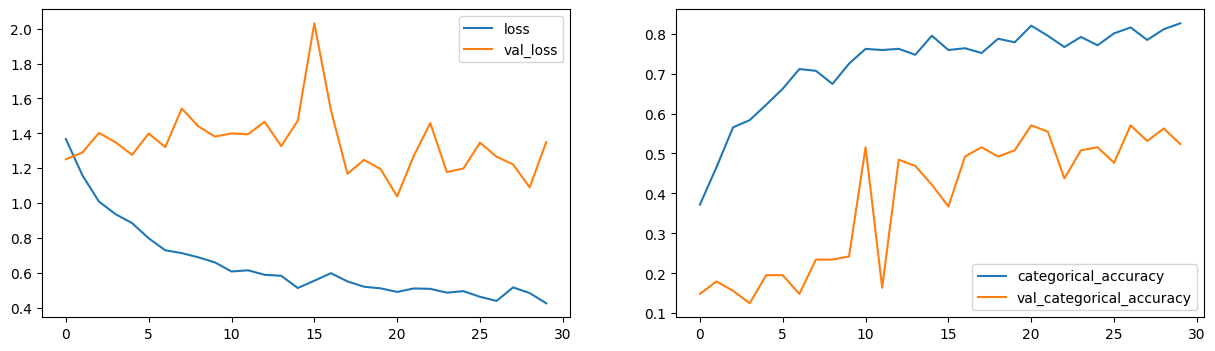

In [ ]:
#Plotting the graph for catagorical and validation accuracy and loss
plot(history)

### **Final Model**
**We select Model 7 of Architecture I (3D Convolution + Maxpooling with lower spatial dimension + GlobalAveragePooling3D + Droupouts + Batch normalization) as the final model**

In [ ]:
#Creating the model
 model = Sequential()

 model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
 model.add(Conv3D(64, kernel_size=3, activation='relu'))
 model.add(MaxPooling3D(pool_size=(2, 2, 2)))
 model.add(BatchNormalization())
 model.add(Dropout(0.2))

 model.add(Conv3D(128, kernel_size=3, activation='relu'))
 model.add(MaxPooling3D(pool_size=(1, 2, 2)))
 model.add(BatchNormalization())
 model.add(Dropout(0.2))

 model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
 model.add(MaxPooling3D(pool_size=(1, 2, 2)))
 model.add(BatchNormalization())
 model.add(Dropout(0.2))

 model.add(GlobalAveragePooling3D())
 model.add(Dense(512, activation='relu'))
 model.add(BatchNormalization())
 model.add(Dense(5, activation='softmax'))


In [ ]:
# model compilation
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 12, 118, 118, 32)  2624      
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 116, 116, 64)  55360     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 58, 58, 64)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 5, 58, 58, 64)    256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 5, 58, 58, 64)     0         
                                                                 
 conv3d_2 (Conv3D)           (None, 3, 56, 56, 128)    2

In [ ]:
#Creating train and Validation generator

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:

#defining callback and fitting the model
#Creating the file path to save the model
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]


In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /kaggle/input/gesturerecognision/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 2.4771 - categorical_accuracy: 0.2679Source path =  /kaggle/input/gesturerecognision/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2023-11-0810_07_25.620327/model-00001-2.47709-0.26786-681.95544-0.17969.h5
21/21 [==============================] - 121s 5s/step - loss: 2.4771 - categorical_accuracy: 0.2679 - val_loss: 681.9554 - val_categorical_accuracy: 0.1797 - lr: 0.0100
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.8191 - categorical_accuracy: 0.3482
Epoch 2: saving model to model_init_2023-11-0810_07_25.620327/model-00002-1.81906-0.34821-353.12943-0.19531.h5
21/21 [==============================] - 44s 2s/step - loss: 1.8191 - categorical_accuracy: 0.3482 - val_loss: 353.1294 - val_categorical_accuracy: 0.1953 - lr: 0.0100
Epoch 3/30
21/21 [==============================] - ETA: 0s -

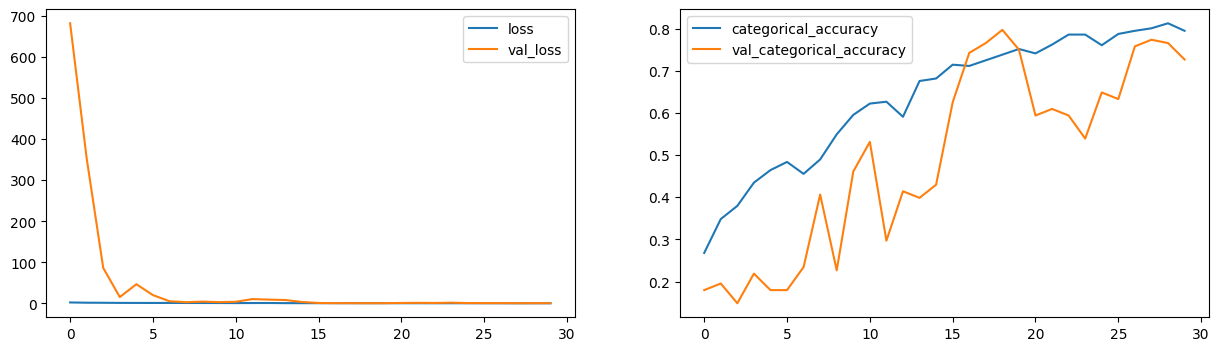

In [ ]:
plot(history)

#### We use **model-00029-0.44855-0.81250-0.65336-0.76562.h5** as our final model with the following performance metrics:
#### loss: 0.4486
#### val_loss: 0.6534
#### categorical_accuracy: 0.8125  
#### val_categorical_accuracy: 0.7656